In [1]:
# Project
import os
print(os.getcwd())
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import matplotlib.pyplot as plt
import random as random
import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import statsmodels.formula.api as smf
import timeit
# Imports functions from seperate notebook
%run Functions.ipynb

C:\Users\Matt\Downloads\CMSE project


Here I load in the data and spit out some summary statistics.

In [2]:
# Reading in Data
start_time = timeit.default_timer()
# Keys to extract formatted State and County names
key = pd.read_excel('fips_codes_website.xls')   # Counties and major cities
key00 = pd.read_csv('FIPS_countycodes.txt',delimiter=',')  # Counties only
key00['GU Name'] = key00['GU Name'].str[:-7]  # Slice 'county' from names
# Housing Data
zillow2019 = pd.read_excel("County_Zhvi_Summary_AllHomes2019.xls")
zillow2019['RegionName'] = zillow2019['RegionName'].str[:-7]  # Slice 'county' from names
# Crime
crime2010 = pd.read_csv('33523-0001-crimedata2010.txt',delimiter='\t')
crime2012 = pd.read_csv('35019-0001-crimedata2012.txt',delimiter='\t')
crime2014 = pd.read_csv('36399-0001-crimedata2014.txt',delimiter='\t')
crime2016 = pd.read_csv('37059-0001-crimedata2016.txt',delimiter='\t')
# Enumployment & Wages
#test_wages_18 = pd.read_excel('allhlcn183.xlsx',sheet_name='US_St_Cn_MSA')
wage_unemp2018 = pd.read_csv('allhlcn183wage_unemp2018.txt',delimiter='\t',dtype={'St':str})
wage_unemp2016 = pd.read_csv('allhlcn163wage_unemp2016.txt',delimiter='\t',dtype={'St':str})
wage_unemp2014 = pd.read_csv('allhlcn143wage_unemp2014.txt',delimiter='\t',dtype={'St':str})
wage_unemp2012 = pd.read_csv('allhlcn123wage_unemp2012.txt',delimiter='\t',dtype={'St':str})
wage_unemp2010 = pd.read_csv('allhlcn103wage_unemp2010.txt',delimiter='\t',dtype={'St':str})

print("2014 crime:",crime2014.shape,"// key:",key.shape)
print("2019 Housing:",zillow2019.shape)
print('2018 Wages:',wage_unemp2018.shape)
x = ((crime2014.shape[0])*(crime2014.shape[1]))*4 + ((wage_unemp2018.shape[0])*(wage_unemp2018.shape[1]))*5 + (key00.shape[0])*key00.shape[1]
print(x,'unique datapoints in all datasets')
elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')

2014 crime: (3177, 56) // key: (41787, 7)
2019 Housing: (1921, 17)
2018 Wages: (62724, 21)
7313843 unique datapoints in all datasets
7.868 run time


In [3]:
# Data Cleaning #
start_time = timeit.default_timer()
# Yearly cleaned databases
crime10 = crime_cleaner(crime2010)
crime12 = crime_cleaner(crime2012)
crime14 = crime_cleaner(crime2014)
crime16 = crime_cleaner(crime2016)
cols = list(crime14.columns.values) # Grab columns
# Cleaned Wage Data
economic10 = wage_cleaner(wage_unemp2010) # Returns 3 items; county, state, national, and urban level data sets
economic12 = wage_cleaner(wage_unemp2012)
economic14 = wage_cleaner(wage_unemp2014)
economic16 = wage_cleaner(wage_unemp2016)
economic18 = wage_cleaner(wage_unemp2018)
economic18['Industry'] = economic18['Industry'].str[1:] # Remove first space in 2018 industry codes

# Combined crime and economic dataframes and rearrange columns
db2010 = crime10.merge(economic10,left_on=['State Abbreviation','GU Name'],right_on=['State Abbreviation','GU Name'])
cols = db2010.columns.tolist()  # Code to rearrange columns
cols = ['Year']+cols[:-14]+cols[-10:]
db2010 = db2010[cols]
db2012 = crime12.merge(economic12,left_on=['State Abbreviation','GU Name'],right_on=['State Abbreviation','GU Name'])
db2012 = db2012[cols]
db2014 = crime14.merge(economic14,left_on=['State Abbreviation','GU Name'],right_on=['State Abbreviation','GU Name'])
db2014 = db2014[cols]
db2016 = crime16.merge(economic16,left_on=['State Abbreviation','GU Name'],right_on=['State Abbreviation','GU Name'])
db2016 = db2016[cols]
elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')

C:\Users\Matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

11.23 run time


In [4]:
# Selects X Random counties and stores them as a dictionary by count // Key = MI, County
start_time = timeit.default_timer()
samp_db = {}
for n in range(100):
    r = random.randint(0,len(crime12))
    x = crime12['State Abbreviation'].iloc[r] # Pull State Abreviation
    y = crime12['GU Name'].iloc[r]  # Pull analogous county name
    z = x+', '+y # Format name for dictionary key
    agg = test_search(y,x) # Return criminal and economic data
    samp_db[z] = agg  # Add data to empty dictionary
keys = list(samp_db.keys())
print(len(samp_db))
print(samp_db.keys())
elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')

98
dict_keys(['KY, Logan', 'MS, Harrison', 'IL, Edgar', 'GA, Haralson', 'KY, Barren', 'FL, Hernando', 'SD, Tripp', 'WV, Jackson', 'KS, Chautauqua', 'WY, Hot Springs', 'IL, Fulton', 'NC, Gates', 'GA, Quitman', 'SC, Dillon', 'MN, Wright', 'LA, Iberville', 'OR, Grant', 'PA, Fayette', 'NC, Polk', 'VA, York', 'CO, Mesa', 'TX, Franklin', 'TX, McMullen', 'OK, McCurtain', 'KY, Letcher', 'KY, Knott', 'KS, Atchison', 'CA, Mono', 'NJ, Warren', 'KS, Brown', 'TX, Mills', 'KS, Cowley', 'NC, Alexander', 'WI, Jefferson', 'AZ, La Paz', 'TN, Grundy', 'SD, Sanborn', 'NE, Nuckolls', 'CO, Custer', 'GA, Jones', 'SC, Dorchester', 'AL, Pickens', 'AL, Baldwin', 'MO, Pulaski', 'MS, Tallahatchie', 'SC, Chester', 'IA, Appanoose', 'PA, Monroe', 'AK, Ketchikan Gateway ', 'IA, Dubuque', 'TX, DeWitt', 'GA, Seminole', 'AR, Little River', 'RI, Bristol', 'NE, Sioux', 'TX, Baylor', 'TX, Hall', 'MO, Dent', 'CO, Montrose', 'NE, Cheyenne', 'PA, Union', 'GA, Oglethorpe', 'AR, Montgomery', 'IL, Clay', 'GA, Brooks', 'NM, Hidal

In [5]:
# Select 5 biggest industries in sample
start_time = timeit.default_timer()
industry = big_industry_bot(samp_db)
print('5 Largest Industries:\n',industry)
elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')

5 Largest Industries:
 ['Goods-producing', 'Service-providing', 'Trade, transportation, and utilities', 'Financial activities', 'Professional and business services']
0.039 run time


In [6]:
start_time = timeit.default_timer()
# Initialize sample to new variable for trouble shooting // preserve OG sample data
bedrock = samp_db

# start base data frame -- create new dataframe, still need to account for various industries
new_world = pd.DataFrame()

for a in keys:
    for b in industry[:]:
        x = bedrock[a].loc[bedrock[a]['Industry'] == b] #
        new_world = new_world.append(x)
        
new_world = new_world.reset_index()  # reset index
new_world = new_world.drop('index',axis=1)  # drop index column
cols = new_world.columns.tolist() # rearrange columns
cols = cols[:3]+cols[-9:]+cols[3:48]
new_world = new_world[cols]

elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')
new_world.head(10)

4.272 run time


,Year,State Abbreviation,GU Name,Industry,Establishment Count,July Employment,August Employment,September Employment,Total Quarterly Wages,Average Weekly Wage,...,OFAGFAM,DUI,LIQUOR,DRUNK,DISORDR,VAGRANT,ALLOTHR,SUSPICN,CURFEW,RUNAWAY
0,2010,KY,Logan,Goods-producing,118,"3,128","3,175",3130,"34,758,955",850,...,34,208,0,107,27,0,533,0,0,0
1,2012,KY,Logan,Goods-producing,123,"3,134","3,170",3159,"37,294,127",909,...,41,218,0,145,30,0,508,0,0,0
2,2014,KY,Logan,Goods-producing,120,"3,440","3,410",3432,"43,260,681",971,...,30,155,0,84,21,0,585,0,0,0
3,2016,KY,Logan,Goods-producing,127,"3,509","3,515",3500,"49,631,544",1088,...,18,130,0,61,28,0,748,0,0,0
4,2010,KY,Logan,Service-providing,399,"3,670","3,616",3641,"24,057,548",508,...,34,208,0,107,27,0,533,0,0,0
5,2012,KY,Logan,Service-providing,417,"3,492","3,522",3502,"25,727,549",565,...,41,218,0,145,30,0,508,0,0,0
6,2014,KY,Logan,Service-providing,436,"3,627","3,627",3605,"27,569,257",586,...,30,155,0,84,21,0,585,0,0,0
7,2016,KY,Logan,Service-providing,439,"3,594","3,612",3592,"28,241,337",604,...,18,130,0,61,28,0,748,0,0,0
8,2010,KY,Logan,"Trade, transportation, and utilities",148,"1,288","1,228",1263,"8,509,576",520,...,34,208,0,107,27,0,533,0,0,0
9,2012,KY,Logan,"Trade, transportation, and utilities",158,"1,294","1,296",1295,"10,255,847",609,...,41,218,0,145,30,0,508,0,0,0


In [7]:
# Set maximum row value
c = 0
for b in samp_db:
    if len(samp_db[b]) > c:
        c = len(samp_db[b])
    #print(b)
print(c)

72


In [8]:
start_time = timeit.default_timer()
crimes = cols[12:]
# Create a list of all industry data entrys
l1 = []
for a in new_world['Industry']:
    l1.append(a)
print('Count of target industries in sample \n\n MUST ALL BE SAME\n')
# Find count of each indutry in sample
l2 = []
for a in industry:
    #print(a,'//',l1.count(a)) # Print out count of each industry in data frame
    l2.append(l1.count(a))

c = l2[0]
for a in l2[1:]:
    if a == c:
        print('Check')
    else:
        print('Failed Industry Count Check')

elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')

Count of target industries in sample 

 MUST ALL BE SAME

Check
Check
Check
Check
0.002 run time


In [9]:
start_time = timeit.default_timer()
# Create final data frame that accounts for metrics across industries
samp_dic = {}
stat = ['Establishment Count','Average Weekly Wage','August Employment']

for s in stat:
    for n in industry:
        samp_dic[n+' '+s] = test_func(new_world,keys,s,n)

for a in crimes:
    samp_dic[a] = test_funk(bedrock,a)
    
finaldb = pd.DataFrame(data=samp_dic)

print(samp_dic.keys(),'\n\n')
elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')
finaldb.head(10)

dict_keys(['Goods-producing Establishment Count', 'Service-providing Establishment Count', 'Trade, transportation, and utilities Establishment Count', 'Financial activities Establishment Count', 'Professional and business services Establishment Count', 'Goods-producing Average Weekly Wage', 'Service-providing Average Weekly Wage', 'Trade, transportation, and utilities Average Weekly Wage', 'Financial activities Average Weekly Wage', 'Professional and business services Average Weekly Wage', 'Goods-producing August Employment', 'Service-providing August Employment', 'Trade, transportation, and utilities August Employment', 'Financial activities August Employment', 'Professional and business services August Employment', 'MURDER', 'P1TOT', 'P1VLNT', 'P1PRPTY', 'RAPE', 'ROBBERY', 'AGASSLT', 'BURGLRY', 'LARCENY', 'MVTHEFT', 'ARSON', 'OTHASLT', 'FRGYCNT', 'FRAUD', 'EMBEZL', 'STLNPRP', 'VANDLSM', 'WEAPONS', 'COMVICE', 'SEXOFF', 'DRUGTOT', 'DRGSALE', 'COCSALE', 'MJSALE', 'SYNSALE', 'OTHSALE', '

,Goods-producing Establishment Count,Service-providing Establishment Count,"Trade, transportation, and utilities Establishment Count",Financial activities Establishment Count,Professional and business services Establishment Count,Goods-producing Average Weekly Wage,Service-providing Average Weekly Wage,"Trade, transportation, and utilities Average Weekly Wage",Financial activities Average Weekly Wage,Professional and business services Average Weekly Wage,...,OFAGFAM,DUI,LIQUOR,DRUNK,DISORDR,VAGRANT,ALLOTHR,SUSPICN,CURFEW,RUNAWAY
0,118,399,148,45,51,850,508,520,649,403,...,34,208,0,107,27,0,533,0,0,0
1,123,417,158,44,61,909,565,609,686,464,...,41,218,0,145,30,0,508,0,0,0
2,120,436,155,47,62,971,586,655,700,537,...,30,155,0,84,21,0,585,0,0,0
3,127,439,151,46,66,1088,604,704,753,560,...,18,130,0,61,28,0,748,0,0,0
4,645,3696,1107,538,698,830,583,608,743,635,...,141,2184,143,797,1451,0,7003,0,183,12
5,537,3707,1088,538,667,880,565,599,760,654,...,255,1708,94,1217,1008,2,2959,3,90,15
6,544,3767,1084,577,686,928,593,618,794,702,...,226,1598,59,1399,834,72,3432,0,66,4
7,511,3877,1102,576,707,965,616,653,849,766,...,236,1681,40,1096,854,3,3814,2,39,0
8,86,288,105,29,45,835,544,540,721,519,...,0,0,0,0,0,0,0,0,0,0
9,82,285,99,31,47,797,548,551,754,532,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Check to ensure that data frame is made of only int64 values
start_time = timeit.default_timer()
x = finaldb.dtypes
x = pd.DataFrame(data=x)
x = x.transpose()
# Create list of column names that are not int64
target = []
for a in x:
    if x[a][0] == 'object':
        b = str(x[a])[:-15]
        b = b[18:]
        target.append(b)
# Convert string columns to interger columns
for a in target:
        finaldb[a] = finaldb[a].str.replace(',','')
        finaldb[a] = finaldb[a].astype(int)
        #print(finaldb[a])
elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')

0.044 run time


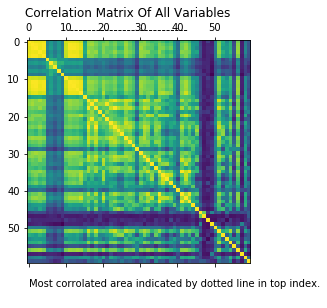


10 highest total correlations:
['P1TOT', 'P1VLNT', 'P1PRPTY', 'RAPE', 'ROBBERY', 'AGASSLT', 'BURGLRY', 'LARCENY', 'MVTHEFT']


,P1TOT,Service-providing August Employment,Financial activities Establishment Count,"Trade, transportation, and utilities August Employment",DRUGTOT,P1PRPTY,Financial activities August Employment,Service-providing Establishment Count,DUI,"Trade, transportation, and utilities Establishment Count"
0,39.4921,39.295388,38.83519,38.730566,38.690349,38.529612,38.515856,38.505248,38.446511,38.42824


In [14]:
corrdb = finaldb.corr().abs().sum()
corrdb = pd.DataFrame(data=corrdb).nlargest(10,0).transpose()
# Creates a correlation matrix of all variables
plt.matshow(finaldb.corr())
plt.suptitle('Correlation Matrix Of All Variables\n')
plt.title('           ---------------------------',loc='left')
plt.annotate('Most corrolated area indicated by dotted line in top index.\n',(0,0),(0,69))
plt.show()
cols = finaldb.columns.tolist()
print('\n10 highest total correlations:')
print(finaldb.columns.tolist()[16:25])
corrdb

In [15]:
print('--Index of most correlated variables(highest to lowest)--')
for i in corrdb:
    print(i+' index:',finaldb.columns.get_loc(i))

--Index of most correlated variables(highest to lowest)--
P1TOT index: 16
Service-providing August Employment index: 11
Financial activities Establishment Count index: 3
Trade, transportation, and utilities August Employment index: 12
DRUGTOT index: 35
P1PRPTY index: 18
Financial activities August Employment index: 13
Service-providing Establishment Count index: 1
DUI index: 51
Trade, transportation, and utilities Establishment Count index: 2


**REGRESSIONS**

In [16]:
x = finaldb[list(finaldb.columns.values[:15])]  # Select columns to use as independant vars
y = finaldb['DUI']  # Set y variable

model = sm.OLS(y, x.astype(float)).fit()
predictions = model.predict(x) # make the predictions by the model

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    DUI   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     154.7
Date:                Mon, 20 May 2019   Prob (F-statistic):          1.11e-150
Time:                        17:27:22   Log-Likelihood:                -2520.7
No. Observations:                 392   AIC:                             5071.
Df Residuals:                     377   BIC:                             5131.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------